# Training conditional Generative Flow Networks

So far, GFNs have been used to learn a parameterized density model $p_\theta(x) \propto R(x)$ for some given $R$.

Can we use this framework to train conditional generative models $p(x|\omega) \propto R(x|\omega)$? In particular, can we use these conditional models to:
- learn to tradeoff between various reward signals, e.g. where $R(x|\omega) = \sum_i \omega_i R_i(x)$ s.t. $\sum_i \omega_i = 1$
- learn to tradeoff between exploratory and greedy behaviors, i.e. learn $R(x|\beta) = R(x)^\beta$ and the corresponding $p$.

Let's look at a few simple scenarios. 

In this notebook, I'm using the [Trajectory Balance](https://arxiv.org/abs/2201.13259) objective, and the corresponding implementation [here](https://github.com/recursionpharma/gflownet/blob/trunk/gflownet/examples/grid_cond_gfn.py).

In the [original GFlowNet paper](https://folinoid.com/w/gflownet/) we learn a flow $F$ such that the in-flows and out-flows of a state $s'$ are balanced:
$$\sum_{(s,a) \to s'} F(s,a) = R(s') + \sum_{a'\in \mathcal{A}(s')} F(s',a')$$
This yields a _forward policy_ $P_F(s \to s') \equiv P_F(a|s)$ which determines the probability of landing in a particular state, and which, at convergence, yields $X \sim F_B \iff p(X) \propto R(X)$. Interestingly, to $P_F$ and $F$ corresponds a _backward_ policy $P_B$, which intuitively, tells you where the flow "came from" in a node.

In Trajectory Balance, it is observed that we have the following, for a sequence of state $(s_t,...,s_T)$:
$$ F(s_t)\prod_{i=t}^{T-1} P_F(s_i \to s_{i+1}) = F(s_T)\prod_{i=t}^{T-1} P_B(s_{i+1} \to s_i)$$
Intuitively, this says that the amount of flow going through a subtrajectory from $s_t$ to $s_T$ must match the reverse flow from $s_T$ to $s_t$. Noting that $F(s_0)=Z$ and $F(s_T)=R(s_T)$ for terminal states, this yields a learning objective over entire trajectories. In TB, we learn $P_F$ (and optionally $P_B$), as well as $Z$.

For a conditional GFN, we are going to learn $Z(\omega; \theta)$ and $P_F(a|s, \omega; \theta)$. In terms of implementation, we simply augment the input of the neural network modeling $P_F$ (and turn $Z$ from a learned single parameter to an MLP as well).


[Setup code]

In [1]:
import grid_cond_gfn as gfn

import torch
import matplotlib.pyplot as pp
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import pickle
import gzip
import numpy as np

 # Some plotting routines
def binavg(x, n=100, var=False, 
            bounds=False, logx=False):
    if len(x) < n:
        return np.linspace(0, len(x), len(x)), x, 0*x+1, 0 * x, np.stack([x, x]).T
    if logx:
        bins = np.logspace(0, np.log(len(x))/np.log(10), n)
        idx = np.digitize(np.arange(len(x)), bins)
    else:
        bins = np.linspace(0, len(x), n)
        idx = np.int32(np.linspace(0, n, len(x)+1))[:-1]
    counts = np.bincount(idx, minlength=n)
    _y = y = np.bincount(idx, x, minlength=n) / counts
    bins = bins[counts>0]
    y = y[counts>0]
    r = (bins, y, counts)
    if var:
        var = np.sqrt(np.bincount(idx, x**2, minlength=n) / np.bincount(idx, minlength=n) - _y**2)
        r += (var[counts>0], )
    if bounds:
        r += (np.float32([(x[idx==i].min(),x[idx==i].max()) for i in range(n) if counts[i] > 0]), ) 
    return r
 
def smooth_plot(x, n=100, fill_var=False, fill_minmax=False, logx=False, **kw):
    bins, y, counts, var, bounds = binavg(x, n, var=True, bounds=True, logx=logx)
    if 'bins' in kw:
        bins = kw.pop('bins')[counts>0]
    l, = pp.plot(bins, y, **kw)
    if fill_var:
        pp.fill_between(bins, y-var, y+var, alpha=0.25, color=l.get_c())
    elif fill_minmax:
        pp.fill_between(bins, bounds[:, 0], bounds[:, 1], alpha=0.25, color=l.get_c())
    return l


top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

mpl.rc('image', cmap=newcmp)

## Trading off between two rewards

Let's now look at two classic optimization functions, the Branin and Currin functions, defined in $[0,1]^2$. We will train a GFN that trades off between these two functions:

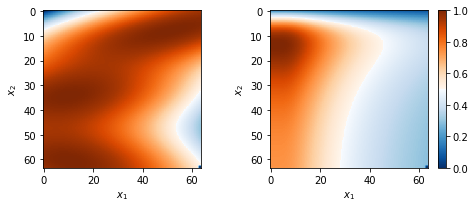

In [2]:
H = 64
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
f, ax = pp.subplots(1,2, figsize=(7,3))
for i in range(2):
    pp.sca(ax[i])
    pp.imshow(np.concatenate([r[:, i], [0]]).reshape((H,H)))
    pp.xlabel('$x_1$')
    pp.ylabel('$x_2$')
pp.colorbar()
pp.tight_layout()

Here is what some convex tradeoffs between these two functions look like:

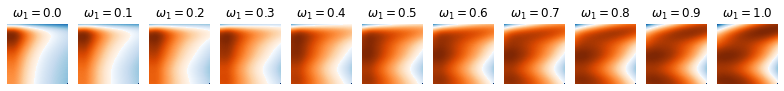

In [3]:
H = 64
env = gfn.GridEnv(64, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
f, ax = pp.subplots(1,11, figsize=(11,2))
for i in range(11):
    pp.sca(ax[i])
    w = i / 10
    y = r[:, 0] * w + r[:, 1] * (1-w)
    pp.imshow(np.concatenate([y, [0]]).reshape((H,H)))
    pp.axis('off')
    pp.title(f'$\omega_1={w}$')
pp.tight_layout()

To make this more interesting let's see how the maxima change if we set the inverse temperature to $\beta = 8$:

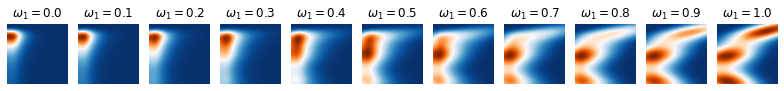

In [4]:
H = 64
env = gfn.GridEnv(64, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
f, ax = pp.subplots(1,11, figsize=(11,2))
for i in range(11):
    pp.sca(ax[i])
    w = i / 10
    y = (r[:, 0] * w + r[:, 1] * (1-w)) ** 8
    pp.imshow(np.concatenate([y, [0]]).reshape((H,H)))
    pp.axis('off')
    pp.title(f'$\omega_1={w}$')
pp.tight_layout()

We can see some fun multimodality happening with the Branin function.

What does the Pareto front of this function look like? Here we scatter the rewards of the discretization (one dot per grid position), red squares are Pareto optimal points.

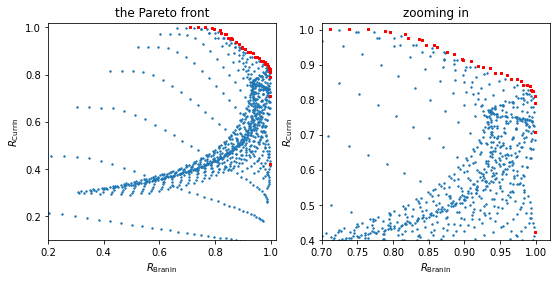

In [6]:
H = 32
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
f, ax = pp.subplots(1,2,figsize=(9,4))
for axi in range(2):
    pp.sca(ax[axi])
    pp.scatter(r[:, 0], r[:, 1], s=2)
    pareto = []
    re = r.T
    for i in range(re.shape[1]):
        d = ((re[:, i, None] - re) < 0).prod(0).sum()
        if d == 0:
            pareto.append(re[:, i])
    pareto = np.float32(pareto)
    pp.scatter(pareto[:, 0], pareto[:, 1], marker='s', s=5, color='red')
    pp.xlim(*[(0.2,1.02), (0.7,1.02)][axi])
    pp.ylim(*[(0.1,1.02), (0.4,1.02)][axi])
    pp.title(['the Pareto front', 'zooming in'][axi])
    pp.xlabel('$R_{\mathrm{Branin}}$')
    pp.ylabel('$R_{\mathrm{Currin}}$')

Let's now look at how a GFN performs on this. To train the GFN, we must notably train it to predict different flows as a function of the conditioning information, here $\omega$ and $\beta$. For $\omega$, we use samples from a Dirichlet(1.5, 1.5), and for $\beta$, samples from a Gamma(2,1) distribution for each new sampled trajectory.

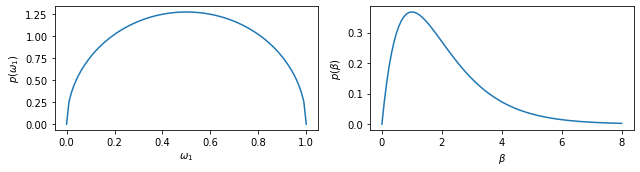

In [7]:
import scipy.stats as stats
f, ax = pp.subplots(1,2,figsize=(9,2.5))
pp.sca(ax[0])
pp.plot(np.linspace(0,1,100), stats.dirichlet.pdf([np.linspace(0,1,100),1-np.linspace(0,1,100)], [1.5,1.5]))
pp.ylabel('$p(\\omega_1)$')
pp.xlabel('$\\omega_1$')
pp.sca(ax[1])
pp.plot(np.linspace(0,8,100), stats.gamma.pdf(np.linspace(0,8,100), 2, scale=1))
pp.ylabel('$p(\\beta)$')
pp.xlabel('$\\beta$')
pp.tight_layout()

We also discretize $[0,1]^2$ into a 16x16 grid in order to apply GFlowNet. We use a small MLP to train $P_F(.|\omega)$ and $Z(\omega)$, and we use a uniform $P_B$.

Now let's look at the convex tradeoff plots again. Here the top row is what is learned and the bottom row the ground truth:

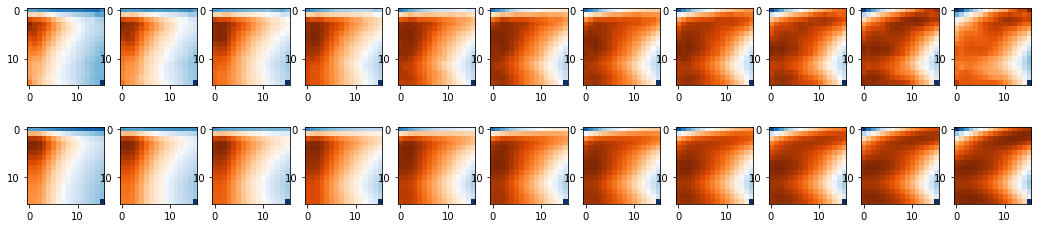

In [8]:
results = pickle.load(gzip.open('results/example_branincurrin.pkl.gz', 'rb'))
f, ax = pp.subplots(2,11,figsize=(18,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
row = 0
for col in range(11):
    coef, temp = results['cond_confs'][col * 5]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, col * 5], [0]]).reshape((H,H)))
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1])**temp, [0]]).reshape((H,H)))

Again with $\beta = 4$:

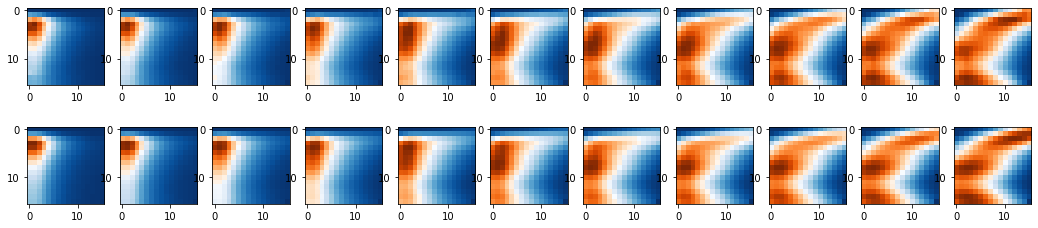

In [9]:
f, ax = pp.subplots(2,11,figsize=(18,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
row = 0
for col in range(11):
    coef, temp = results['cond_confs'][col * 5 + 2]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + 2], [0]]).reshape((H,H)))
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1])**temp, [0]]).reshape((H,H)))

$\beta=8$

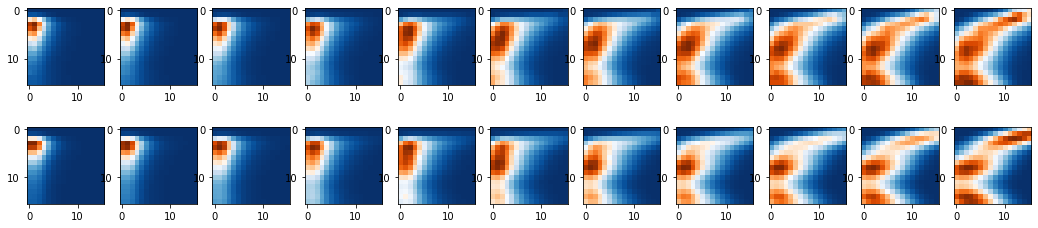

In [10]:
f, ax = pp.subplots(2,11,figsize=(18,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
row = 0
for col in range(11):
    coef, temp = results['cond_confs'][col * 5 + 3]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + 3], [0]]).reshape((H,H)))
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1])**temp, [0]]).reshape((H,H)))

Another fun thing we can look at is how well the model is doing as a function of $\omega$ and $\beta$. Here on the left we show the MAE $\mathbb{E}_x|p(x|\beta,\omega)-p_\theta(x|\beta,\omega)|$ and on the right we show the mean absolute log-error $\mathbb{E}_x|\log p(x|\beta,\omega)-\log p_\theta(x|\beta,\omega)|$:

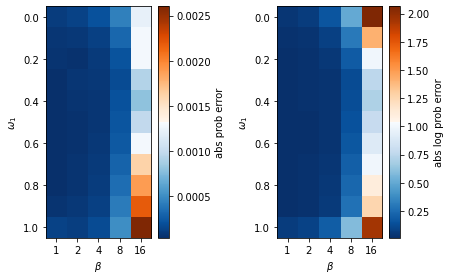

In [11]:
data = results
errs = []
logerrs = []
for (coef, t), dist in zip(data['cond_confs'], data['final_distribution'].T):
    unnorm_p = (r[:, 0]*coef[0]+r[:,1]*coef[1])**t
    Z = unnorm_p.sum()
    p = unnorm_p / Z
    errs.append(abs(dist - p).mean())
    logp = np.log(unnorm_p) - np.log(Z)
    logerrs.append(abs(np.log(dist) - logp).mean())
f, ax = pp.subplots(1,2)
pp.sca(ax[0])
pp.imshow(np.float32(errs).reshape((11,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,11,2), np.arange(0,11,2)/10)
pp.ylabel('$\\omega_1$')
pp.colorbar(label='abs prob error')
pp.sca(ax[1])
pp.imshow(np.float32(logerrs).reshape((11,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,11,2), np.arange(0,11,2)/10)
pp.ylabel('$\\omega_1$')
pp.colorbar(label='abs log prob error')
pp.tight_layout()
pp.subplots_adjust(wspace=0.75)

As noted earlier, since we sample $\omega$ from a Dirichlet that peaks at 0.5, we get (as expected) that the error is a bit higher at the edges (for $\omega_1=0$ and $=1$). Also remember that $\beta$ is sampled from Gamma(2,1), this means the model sees $\beta\geq 8$ only

In [12]:
print(f'{100 - 100 * stats.gamma.cdf(8, 2, scale=1): .2f}%')

 0.30%


of the time! It sees $\beta=16$ even less. Interestingly at this point, it forgets some modes, but remembers the "gist" of it.

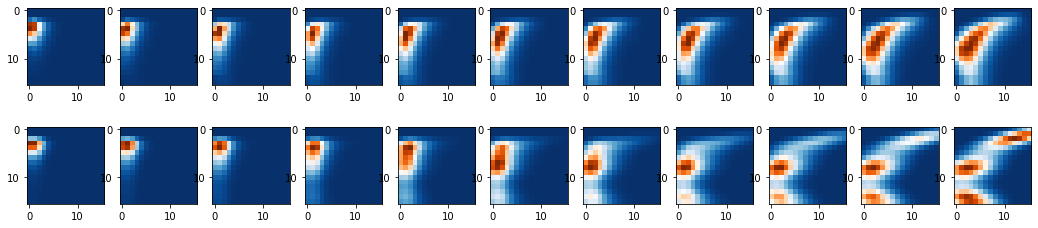

In [13]:
f, ax = pp.subplots(2,11,figsize=(18,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
row = 0
for col in range(11):
    coef, temp = results['cond_confs'][col * 5 + 4]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + 4], [0]]).reshape((H,H)))
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1])**temp, [0]]).reshape((H,H)))

Let's now look at the $Z$ predictions the GFN model is making.

The left plot shows again the error (but this time on $Z$) as a function of $\omega$ and $\beta$. The middle left plot shows the same error but with a different coloring. The two right plots the the predicted and true $\log Z$ values. It's interesting to note here that error is less consistent than with $p(x)$, and also that it may be due to the prediction being "too smooth" as a function of $\omega$.

In [14]:
agent = gfn.FlowNet_TBAgent(data['args'], [env])
for a,b in zip(agent.parameters(), data['params']):
    a.data = torch.tensor(b)
preds = []
for coef, t in data['cond_confs']:
    env.reset(coef, t)
    preds.append((agent.Z(torch.tensor(env.cond_obs).float()).item(), np.log(((r[:, 0]*coef[0]+r[:,1]*coef[1])**t).sum())))

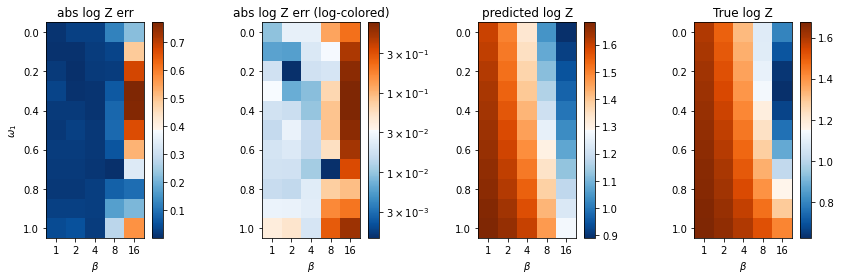

In [15]:
preds = np.float32(preds)
f, ax = pp.subplots(1,4,figsize=(12,4))
pp.sca(ax[0])
err = abs(preds[:, 0] - preds[:,1])
pp.imshow(err.reshape((11,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,11,2), np.arange(0,11,2)/10)
pp.ylabel('$\\omega_1$')
pp.colorbar()
pp.title('abs log Z err')

pp.sca(ax[1])
err = np.log(abs(preds[:, 0] - preds[:,1])) / np.log(10)
pp.imshow(err.reshape((11,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,11,2), np.arange(0,11,2)/10)
#pp.ylabel('$\\omega_1$')
pp.title('abs log Z err (log-colored)')
cb = pp.colorbar(ticks=np.linspace(-2.5,0.5,7))
cb.ax.set_yticklabels([f'${m}\\times 10^{{{int(e)}}}$' for i in np.linspace(-2.5,0.5,7) for m,e in [f'{10**i:.0E}'.split('E')]])

pp.sca(ax[2])
err = np.log(preds[:, 0])
pp.imshow(err.reshape((11,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,11,2), np.arange(0,11,2)/10)
pp.title('predicted log Z')
pp.colorbar()

pp.sca(ax[3])
err = np.log(preds[:, 1])
pp.imshow(err.reshape((11,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,11,2), np.arange(0,11,2)/10)
pp.title('True log Z')
pp.colorbar()
pp.tight_layout()

Let's finally plot the training loss of the model:

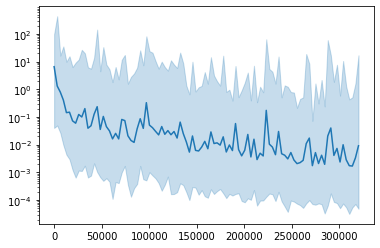

In [16]:
l = smooth_plot(np.float32(data['losses'])[:,0], 100, fill_minmax=True)
pp.yscale('log')

It seems high variance, but at least going down consistently. In particular I'm also filling the min/max values of the loss, and there does seem to be the occasional very high loss.

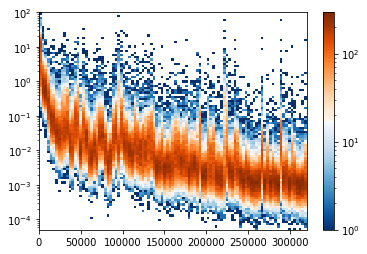

In [17]:
import matplotlib.colors as colors
x, y = np.arange(len(data['losses'])), np.float32(data['losses'])[:,0]
pp.hist2d(x,y, [np.linspace(0, len(x), 100), np.logspace(-4.3, 2, 100)], norm=colors.LogNorm())
pp.yscale('log')
pp.colorbar()

### Running experiments

In this notebook I've directly loaded pickled results from a previous run. You can run the provided code, or try it out from directly from this notebook (lots of CPUs recommended). For example:

In [18]:
import grid_cond_gfn as gfn
hps = gfn.parser.parse_args([])
hps.save_path = None 
hps.progress = True
hps.horizon = 16
hps.n_train_steps = 1000 # The more steps the better
hps.opt = 'adam'
hps.mbsize = 128
hps.learning_rate = 1e-2
hps.n_hid = 64
hps.n_layers = 3

# To make this experiment run faster, batching can be parallelised over multiple cpus:
hps.n_procs = 32

results = gfn.main(hps)

0.01622 4.82535: 100%|██████████| 1001/1001 [02:48<00:00,  5.95it/s]


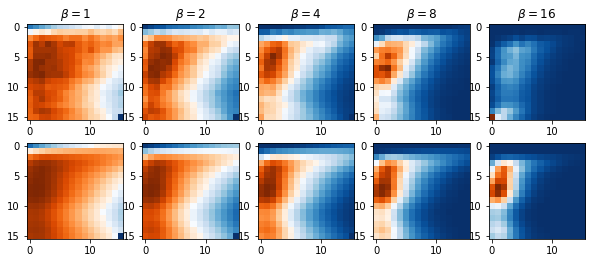

In [19]:
f, ax = pp.subplots(2,5,figsize=(5*2,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
row = 0
for col in range(5):
    coef, temp = results['cond_confs'][5 * 5 + col]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, 5 * 5 + col], [0]]).reshape((H,H)))
    pp.title(f"$\\beta={temp}$")
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1])**temp, [0]]).reshape((H,H)))

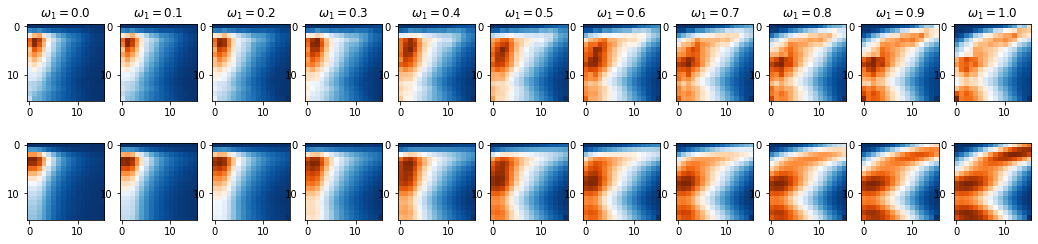

In [20]:
f, ax = pp.subplots(2,11,figsize=(18,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
row = 0
for col in range(11):
    coef, temp = results['cond_confs'][col * 5 + 2]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + 2], [0]]).reshape((H,H)))
    pp.title(f"$\\omega_1={coef[0]:.1f}$")
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1])**temp, [0]]).reshape((H,H)))

Loss:

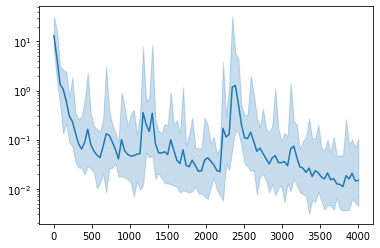

In [21]:
smooth_plot(np.float32(results['losses'])[:,0], 100, fill_minmax=True)
pp.yscale('log')

In [22]:
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
model = gfn.FlowNet_TBAgent(results['args'], [env])
for a, b in zip(model.parameters(), results['params']):
    a.data = torch.tensor(b)
s, r, pos = env.state_info()


Learned logits (down, right, stop):

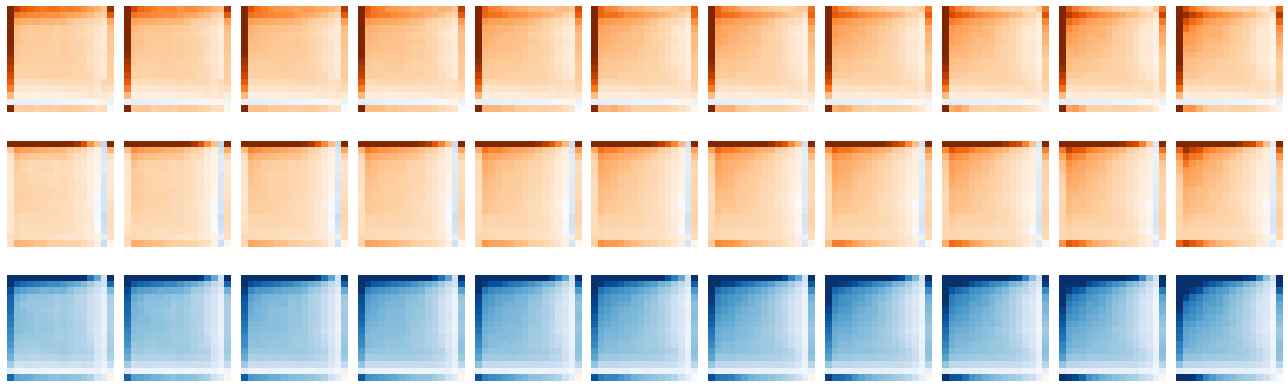

In [23]:
f, ax = pp.subplots(3,11,figsize=(18,6))
for col in range(11):
    #coef, temp = results['cond_confs'][col * 5]
    coef = col / 10
    env.cond_obs = np.float32([coef, 1-coef, 2])
    with torch.no_grad():
        pred = model.model(torch.tensor([env.obs(p) for p in pos]).float())
    for j in range(3):
        pp.sca(ax[j, col])
        pp.imshow(np.concatenate([pred[:, j].numpy(), [0]]).reshape((H,H)), vmin=-2, vmax=2)
        pp.axis('off')
pp.tight_layout()

Learned policy (down, right, stop):

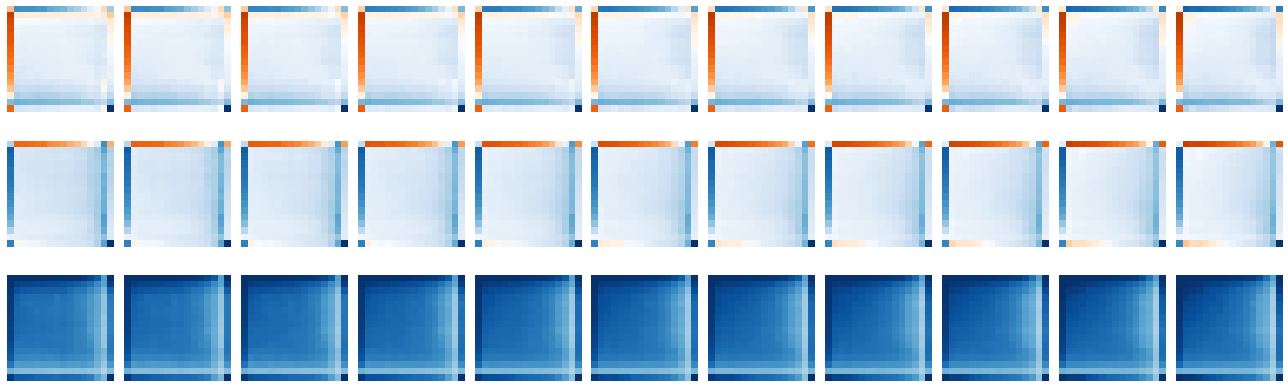

In [24]:
f, ax = pp.subplots(3,11,figsize=(18,6))
sm = torch.nn.Softmax(1)
for col in range(11):
    #coef, temp = results['cond_confs'][col * 5]
    coef = col / 10
    env.cond_obs = np.float32([coef, 1-coef, 2])
    with torch.no_grad():
        pred = sm(model.model(torch.tensor([env.obs(p) for p in pos]).float()))
    for j in range(3):
        pp.sca(ax[j, col])
        pp.imshow(np.concatenate([pred[:, j].numpy(), [0]]).reshape((H,H)), vmin=0, vmax=1)
        pp.axis('off')
pp.tight_layout()